In [22]:
import torch
import torch_geometric
import rdkit
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [29]:
def smiles_to_graph(smiles):
    """Konwertuje SMILES na graf molekularny dla PyTorch Geometric"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Cechy atomów
    x = []
    for atom in mol.GetAtoms():
        atom_features = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            atom.GetHybridization(),
            atom.GetIsAromatic(),
            atom.GetTotalNumHs()
        ]
        x.append(atom_features)
    
    x = torch.tensor(x, dtype=torch.float)
    
    # Krawędzie
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.append([i, j])
        edge_indices.append([j, i])  # Graf nieskierowany
        
    if len(edge_indices) == 0:  # Molekuła bez wiązań
        edge_index = torch.zeros((2, 0), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    
    # Cechy krawędzi (wiązań)
    edge_attr = []
    for bond in mol.GetBonds():
        bond_type = bond.GetBondType()
        is_conjugated = bond.GetIsConjugated()
        is_in_ring = bond.IsInRing()
        bond_features = [
            bond_type == Chem.BondType.SINGLE, 
            bond_type == Chem.BondType.DOUBLE,
            bond_type == Chem.BondType.TRIPLE,
            bond_type == Chem.BondType.AROMATIC,
            is_conjugated,
            is_in_ring
        ]
        # Dodajemy cechę dla obu kierunków krawędzi
        edge_attr.append(bond_features)
        edge_attr.append(bond_features)
    
    if len(edge_attr) == 0:
        edge_attr = torch.zeros((0, 6), dtype=torch.float)
    else:
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

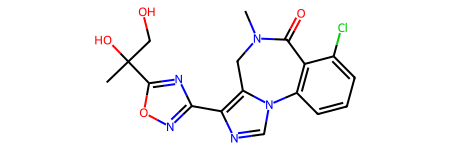

In [30]:
smiles = "OCC(C)(O)c1onc(c2ncn3c2CN(C)C(c4c3cccc4Cl)=O)n1"  # Etanol
molecule = Chem.MolFromSmiles(smiles)
molecule

In [31]:
x = smiles_to_graph(smiles)
x

Data(x=[27, 6], edge_index=[2, 60], edge_attr=[60, 6])

In [33]:
import pyrfume

molecules = pyrfume.load_data(
    "goodscents/molecules.csv"
)  # Load the data we created in the last chapter
cids = molecules.IsomericSMILES.tolist()

In [39]:
for i in cids:
    s = []
    s.apply(smiles_to_graph(smiles))
    print(s)

AttributeError: 'list' object has no attribute 'apply'

In [34]:
cids

['CC(CN)O',
 'CC(C)C(=O)C(=O)O',
 'C(CC(=O)O)C(=O)C(=O)O',
 'CCC(=O)C(=O)O',
 'CC(C)CC(=O)C(=O)O',
 'C1=CC(=C(C=C1C(=O)O)O)O',
 'C1=CC=C(C=C1)CCC(=O)O',
 'C(CC(=O)O)CN',
 'C1=CC(=CC=C1CO)O',
 'C1=CC(=CC=C1C=O)O',
 'C1=CC(=CC=C1C(=O)O)O',
 'CC(=O)O',
 'CC=O',
 'CC(=O)N',
 'CC(C(=O)C)O',
 'CC(=O)C',
 'C(CCC(=O)O)CC(=O)O',
 'N',
 'C1C(C(C(C(O1)O)O)O)O',
 'C(CN)C(=O)O',
 'C1=CC=C(C=C1)C=O',
 'C1=CC=C(C=C1)C(=O)O',
 'C1=CC=C(C=C1)CO',
 'CCCC=O',
 'CC(C(C)O)O',
 'CCCCO',
 'CCCC(=O)O',
 'C(=O)=O',
 'C(=O)O',
 'C1=CC=C(C=C1)C=CC=O',
 'C1=CC=C(C=C1)C=CCO',
 'C(C(=CC(=O)O)C(=O)O)C(=O)O',
 'C(C(=O)O)C(CC(=O)O)(C(=O)O)O',
 'C1=CC=C2C(=C1)C=CC(=O)O2',
 'CC(C)C1=CC=C(C=C1)CO',
 'CC(C)C1=CC=C(C=C1)C=O',
 'COC1=C(C=CC(=C1)C=C)O',
 'CC1=CC=CC=C1O',
 'C1=CC=C(C(=C1)C(=O)O)O',
 'CC1=CC(=CC=C1)O',
 'CCCCCCCC(=O)O',
 'S',
 'C(C(C(=O)O)N)C(=O)O',
 'CCCCCCCC=O',
 'COC1=CC=CC=C1O',
 'C(C(C(=O)O)O)C(=O)O',
 'CCC=O',
 'CSCCC(=O)O',
 'CC(C(=O)O)N',
 'CC(C(=O)O)O',
 'CC(=O)C(=O)C',
 'C1CC(=O)OC2=CC=CC=C21',
 'C(C

In [43]:
def process_smiles_list(smiles_list):
    """Przetwarza listę SMILES na listę grafów molekularnych"""
    graphs = []
    
    for smiles in smiles_list:
        graph = smiles_to_graph(smiles)
        if graph is not None:
            graphs.append(graph)
    
    return graphs

# Przykład użycia:
graphs = process_smiles_list(cids)

print(f"Pomyślnie przetworzono {len(graphs)} z {len(smiles_list)} SMILES")

Pomyślnie przetworzono 4565 z 4 SMILES


In [44]:
graphs

[Data(x=[5, 6], edge_index=[2, 8], edge_attr=[8, 6]),
 Data(x=[8, 6], edge_index=[2, 14], edge_attr=[14, 6]),
 Data(x=[10, 6], edge_index=[2, 18], edge_attr=[18, 6]),
 Data(x=[7, 6], edge_index=[2, 12], edge_attr=[12, 6]),
 Data(x=[9, 6], edge_index=[2, 16], edge_attr=[16, 6]),
 Data(x=[11, 6], edge_index=[2, 22], edge_attr=[22, 6]),
 Data(x=[11, 6], edge_index=[2, 22], edge_attr=[22, 6]),
 Data(x=[7, 6], edge_index=[2, 12], edge_attr=[12, 6]),
 Data(x=[9, 6], edge_index=[2, 18], edge_attr=[18, 6]),
 Data(x=[9, 6], edge_index=[2, 18], edge_attr=[18, 6]),
 Data(x=[10, 6], edge_index=[2, 20], edge_attr=[20, 6]),
 Data(x=[4, 6], edge_index=[2, 6], edge_attr=[6, 6]),
 Data(x=[3, 6], edge_index=[2, 4], edge_attr=[4, 6]),
 Data(x=[4, 6], edge_index=[2, 6], edge_attr=[6, 6]),
 Data(x=[6, 6], edge_index=[2, 10], edge_attr=[10, 6]),
 Data(x=[4, 6], edge_index=[2, 6], edge_attr=[6, 6]),
 Data(x=[10, 6], edge_index=[2, 18], edge_attr=[18, 6]),
 Data(x=[1, 6], edge_index=[2, 0], edge_attr=[0, 6]),

In [ ]:
for i in cids:
    i = smiles_to_graph(smiles)

    return


In [ ]:
[x for x in cids]

In [ ]:
return  ci